# Variogram Point Cloud - tutorial

## Table of Contents:

1. Read point data,
2. Set proper lag size with variogram cloud histogram,
3. Detect and remove outliers.
4. Calculate experimental semivariance from point cloud.

## Level: Basic

## Changelog

| Date       | Change description                                                                                                                                                     | Author                     |
|------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------|
| 2022-08-17 | Updated to the version 0.3.0                                                                                                                                           | @SimonMolinsky             |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function                                                                                                                | @SimonMolinsky             |
| 2021-10-13 | Refactored TheoreticalSemivariogram (name change of class attribute) and refactored `calc_semivariance_from_pt_cloud()` function to protect calculations from `NaN's`. | @ethmtrgt & @SimonMolinsky |
| 2021-08-22 | Refactored the Outlier Removal algorithm - quantile based algorithm                                                                                                    | @SimonMolinsky             |
| 2021-08-10 | Refactored the Outlier Removal algorithm                                                                                                                               | @SimonMolinsky             |
| 2021-05-11 | Refactored TheoreticalSemivariogram class                                                                                                                              | @SimonMolinsky             |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data.                                                                                    | @SimonMolinsky             |

## Introduction

In this tutorial we will learn how to read and prepare data for semivariogram modeling, how to manually find the best step size between lags and how to detect outliers in our data which can affect final semivariogram.

Variogram Point Cloud analysis is an additional, basic data preparation step which may save you a lot of headache with more sophisticated analysis. You should learn about Variogram Point Cloud analysis before you move on to the semivariogram estimation and semivariogram fitting operations.

We use: 

- for point 1 and 2: DEM data which is stored in a file `sample_data/point_data/poland_dem_gorzow_wielkopolski`,
- for point 3: Breast cancer rates data is stored in the shapefile in folder `sample_data/areal_data/breast_cancer_rate_per_area_2.shp`.

## Import packages

In [7]:
import numpy as np

import matplotlib.pyplot as plt

from pyinterpolate.io import read_txt
from pyinterpolate import Blocks, PointSupport
from pyinterpolate.distance.distance import calc_point_to_point_distance
from pyinterpolate.variogram.empirical.variogram_cloud import VariogramCloud
from pyinterpolate.variogram.empirical.experimental_variogram import build_experimental_variogram

## 1) Read point data

In [8]:
dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')

In [9]:
# Look into a first few lines of data

dem[:10, :]

array([[2.37685325e+05, 5.45416708e+05, 5.12545509e+01],
       [2.37674140e+05, 5.45209671e+05, 4.89582825e+01],
       [2.37449255e+05, 5.41045935e+05, 1.68178635e+01],
       [2.37320090e+05, 5.38653518e+05, 1.62939053e+01],
       [2.37187238e+05, 5.36192094e+05, 1.65406628e+01],
       [2.37056908e+05, 5.33776683e+05, 1.94509335e+01],
       [2.37050703e+05, 5.33661664e+05, 1.92426758e+01],
       [2.36890637e+05, 5.30694166e+05, 4.56620102e+01],
       [2.36841016e+05, 5.29774013e+05, 3.37260437e+01],
       [2.36826130e+05, 5.29497967e+05, 3.55447350e+01]])

## 2) Set proper lag size with variogram cloud histogram

In this step we generate Variogram Point Cloud. For each proposed lag algorithm assigns point's values which are grouped in this lag. We check and compare few different lags and step sizes and their respective point clouds.

In [10]:
# Create analysis parameters

# Check max distance between points
distances = calc_point_to_point_distance(dem[:, :-1])
maximum_range = np.max(distances)

number_of_lags = [4, 8, 16, 32]
step_sizes = [maximum_range / x for x in number_of_lags]

variogram_clouds = []

for step_size in step_sizes:
    vc = VariogramCloud(input_array=dem, step_size=step_size, max_range=maximum_range)
    variogram_clouds.append(vc)

Now we check how many points are grouped for each lag:

In [11]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    vc = variogram_clouds[idx]
    for jdx, _lag in enumerate(vc.lags):
        print(f'Lag {_lag} has {vc.points_per_lag[jdx]} points.')
    
    print('\n###########\n')    

Lags per area: 4

Lag 7476.827504864742 has 13826462 points.
Lag 14953.655009729484 has 22113492 points.
Lag 22430.482514594227 has 10437940 points.

###########

Lags per area: 8

Lag 3738.413752432371 has 4134348 points.
Lag 7476.827504864742 has 9692114 points.
Lag 11215.241257297113 has 11633002 points.
Lag 14953.655009729484 has 10480490 points.
Lag 18692.068762161856 has 6926514 points.
Lag 22430.482514594227 has 3511426 points.
Lag 26168.896267026597 has 1069000 points.

###########

Lags per area: 16

Lag 1869.2068762161855 has 1127740 points.
Lag 3738.413752432371 has 3006608 points.
Lag 5607.620628648557 has 4394730 points.
Lag 7476.827504864742 has 5297384 points.
Lag 9346.034381080928 has 5769748 points.
Lag 11215.241257297113 has 5863254 points.
Lag 13084.448133513299 has 5553530 points.
Lag 14953.655009729484 has 4926960 points.
Lag 16822.86188594567 has 4019630 points.
Lag 18692.068762161856 has 2906884 points.
Lag 20561.275638378043 has 2089226 points.
Lag 22430.4825145

### Clarification:

Raw numbers are hard to analyze. But we can check those informations with boxplots and that we can learn more about the data:

Lags per area: 4



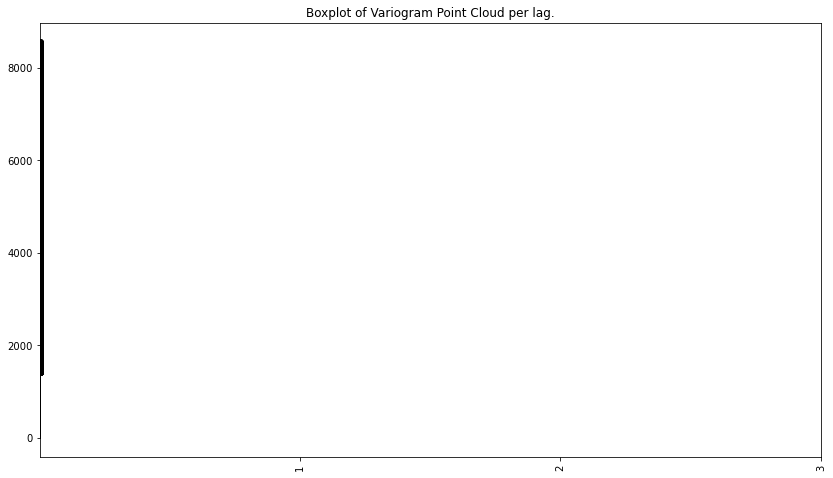


###########

Lags per area: 8



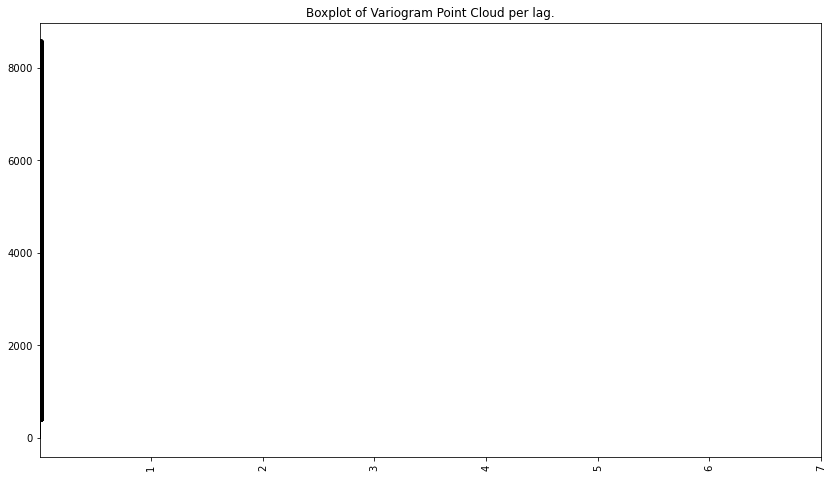


###########

Lags per area: 16



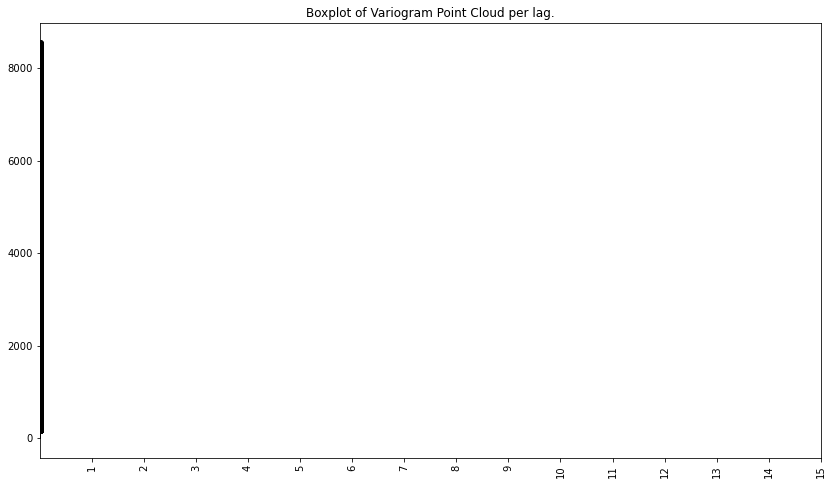


###########

Lags per area: 32



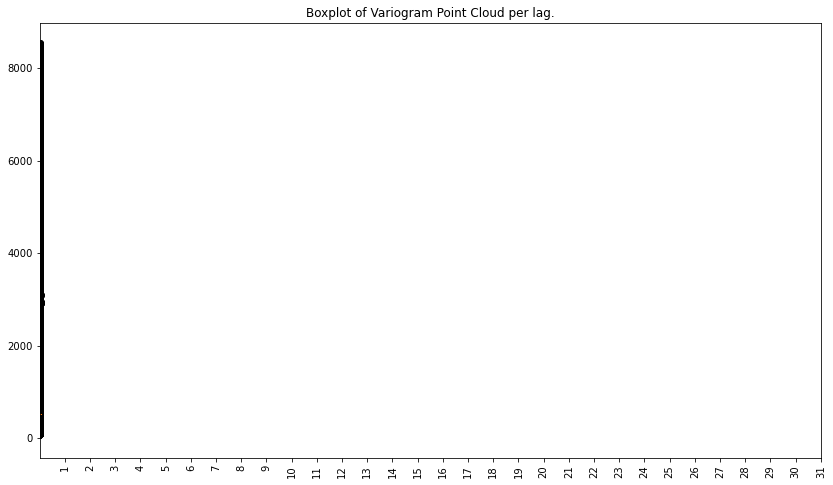


###########



In [12]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    vc = variogram_clouds[idx]
    vc.plot('box')
    
    print('\n###########\n')

### Clarification:

Boxplots of each lag shows halved squared difference (semivariance) between all points grouped for specific lag. The box extends from the lower to upper quartile values of the data, with a line at the median. The whiskers extend from the box to show the range of the data. Flier points are those past the end of the whiskers. As you may observed we have multiple outliers in a dataset, especially for short- and medium-range semivariance values. This may indicate that dataset should be transformed before analysis. Other interesting fact is that from 8 lags we are able to see specific pattern at a distance 0.18. Variogram is not constant and there is one valley in it.

Why do we plot those boxplots?

1. To check outliers in a data.
2. To check if each distance is well represented by specific number of measurements. This is extremely important at a short-distance scale.
3. To gain initial idea how semivariogram may be look like.

For point 3.: we can check experimental semivariogram and compare it with those boxplots here. We will do it for 16 lags.

In [7]:
search_radius = step_sizes[2]
max_range = maximum_range

exp_semivar = calculate_semivariance(data=dem, step_size=search_radius, max_range=max_range)

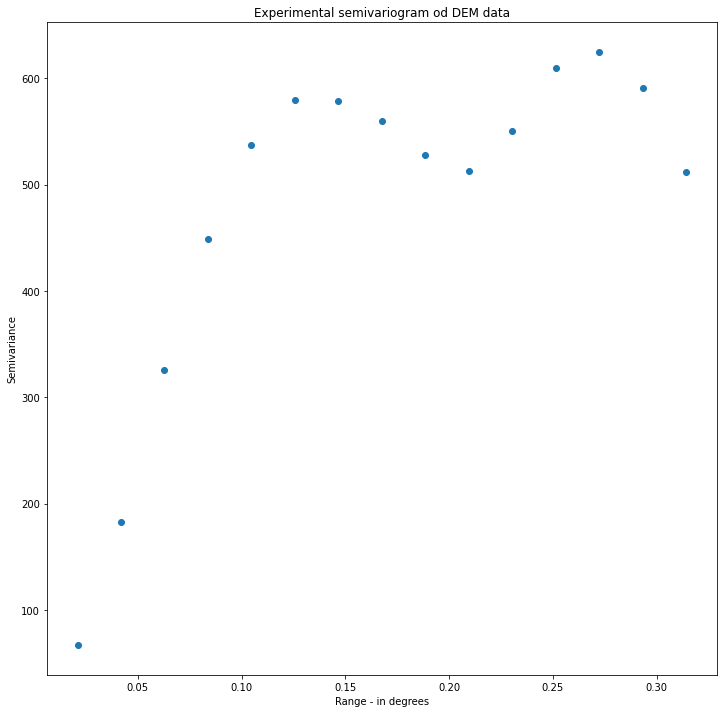

In [8]:
# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1], 'o')
plt.title('Experimental semivariogram od DEM data')
plt.xlabel('Range - in degrees')
plt.ylabel('Semivariance')
plt.show()

### Clarification:

As you may noticed experimental semivariogram has drop of semivariance at 0.2 degree range, which is very close to the drop of variogram point cloud.

## 3) Detect and remove outliers

With idea how Variogram Point Cloud works we can detect and "remove" outliers from our dataset. We use for it other dataset which represents the breast cancer rates in counties of Northeastern part of the U.S. Each county will be transformed into its centroid. Those centroids are not evenly spaced and we can expect that for some number of steps dataset may be modeled incorrectly.

In [9]:
# Read and prepare data

areal_data_file = '../sample_data/areal_data/cancer_data.shp'
areal_id_column_name = 'FIPS'
areal_val_column_name = 'rate'

areal_data = prepare_areal_shapefile(areal_data_file,
                                     id_column_name=areal_id_column_name,
                                     value_column_name=areal_val_column_name)

In [10]:
areal_centroids = areal_data[:, -3:]

In [11]:
# Create analysis parameters

# Check max distance between points

distances = calc_point_to_point_distance(areal_centroids[:, :-1])
maximum_range = np.max(distances)

number_of_lags = [4, 8, 16, 32]
step_sizes = [maximum_range / x for x in number_of_lags]

variogram_clouds = []

for step_size in step_sizes:
    variogram_cloud = build_variogram_point_cloud(areal_centroids, step_size, maximum_range)
    variogram_clouds.append(variogram_cloud)

In [12]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    var_cloud = variogram_clouds[idx]
    for jdx, cloud in enumerate(var_cloud.keys()):
        l = len(var_cloud[cloud])
        print(f'Lag {cloud} has {l} points.')
    
    print('\n###########\n')

Lags per area: 4

Lag 301214.2660116966 has 20462 points.
Lag 602428.5320233932 has 20568 points.
Lag 903642.7980350899 has 5296 points.

###########

Lags per area: 8

Lag 150607.1330058483 has 6676 points.
Lag 301214.2660116966 has 13786 points.
Lag 451821.3990175449 has 12970 points.
Lag 602428.5320233932 has 7598 points.
Lag 753035.6650292415 has 3784 points.
Lag 903642.7980350897 has 1512 points.
Lag 1054249.9310409382 has 450 points.

###########

Lags per area: 16

Lag 75303.56650292415 has 1936 points.
Lag 150607.1330058483 has 4740 points.
Lag 225910.69950877246 has 6532 points.
Lag 301214.2660116966 has 7254 points.
Lag 376517.83251462074 has 7066 points.
Lag 451821.39901754487 has 5904 points.
Lag 527124.9655204691 has 4494 points.
Lag 602428.5320233932 has 3104 points.
Lag 677732.0985263174 has 2220 points.
Lag 753035.6650292416 has 1564 points.
Lag 828339.2315321657 has 980 points.
Lag 903642.7980350899 has 532 points.
Lag 978946.364538014 has 290 points.
Lag 1054249.93104

Lags per area: 4



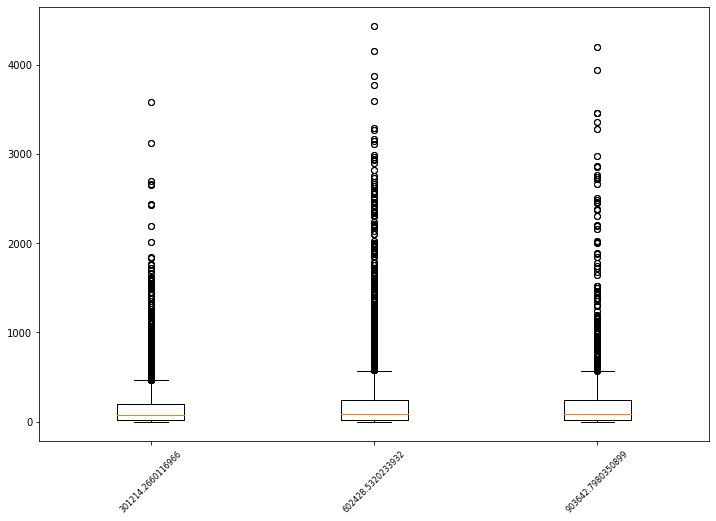


###########

Lags per area: 8



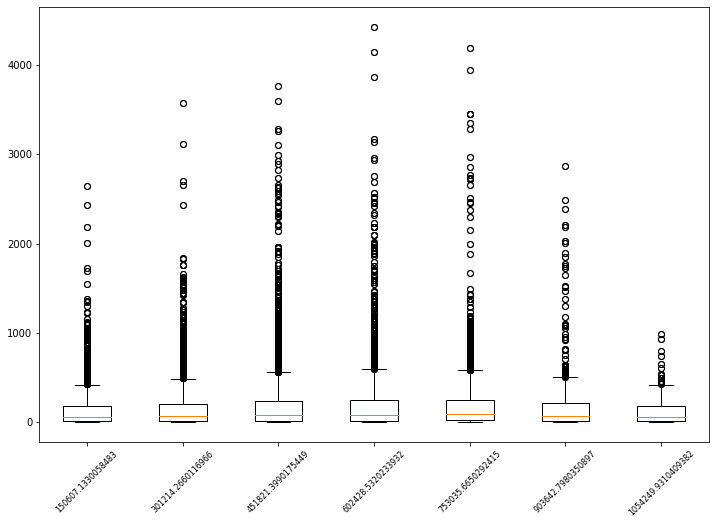


###########

Lags per area: 16



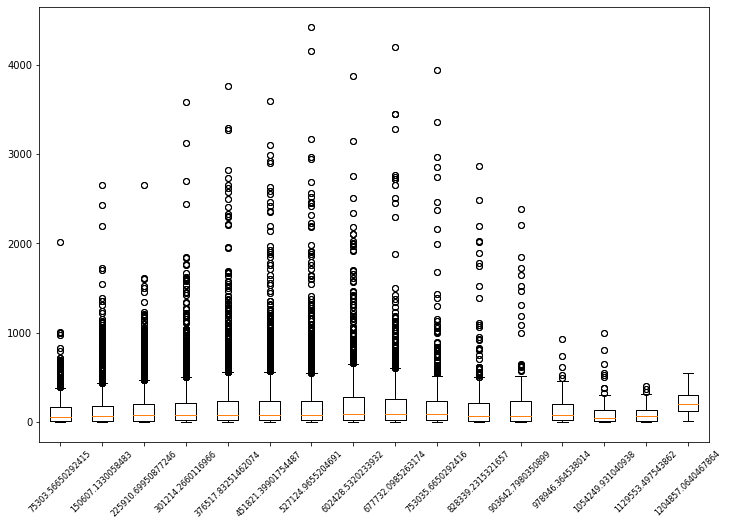


###########

Lags per area: 32



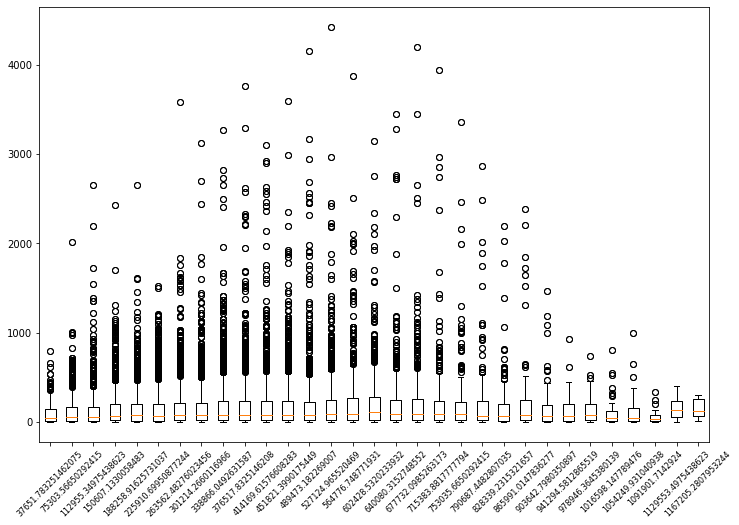


###########



In [13]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    var_cloud = variogram_clouds[idx]
    show_variogram_cloud(var_cloud, figsize=(12, 8))
    
    print('\n###########\n')

### Clarification

1. There are some outliers in a dataset! To get rid of them we will remove all TOP values which are further away from the mean than 2 standard deviations (for each lag).

In [14]:
cloud_without_outliers = remove_outliers(variogram_clouds[2], exclude_part='top')

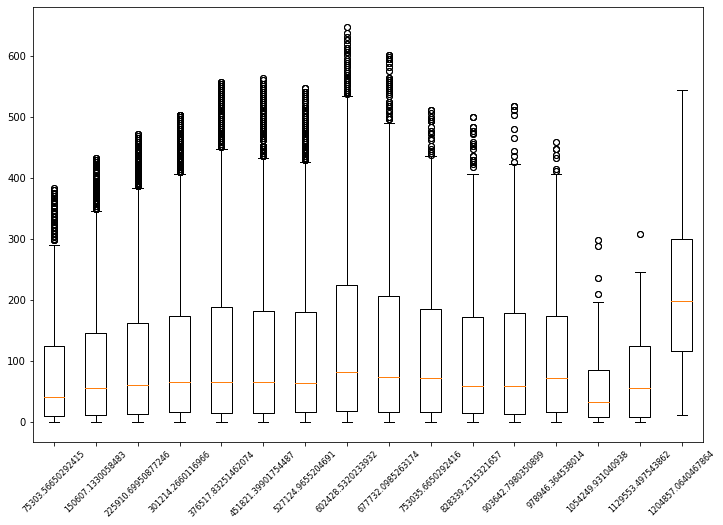

In [15]:
show_variogram_cloud(cloud_without_outliers, figsize=(12, 8))

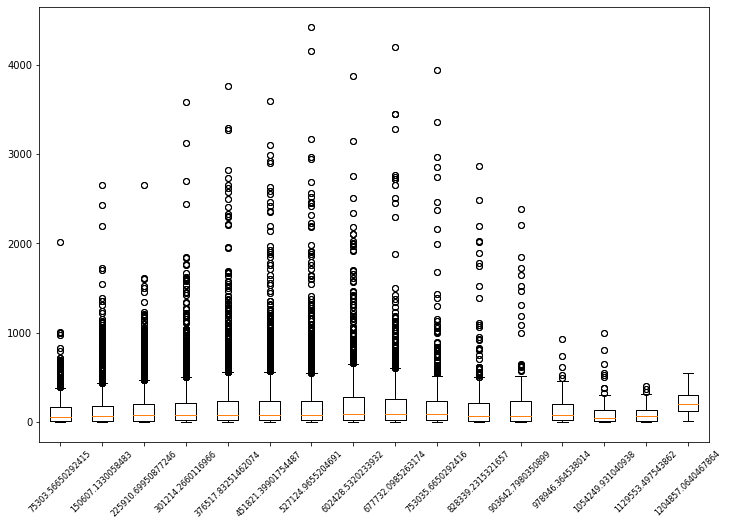

In [16]:
show_variogram_cloud(variogram_clouds[2], figsize=(12, 8))

### Clarification:

Compare y axis of two figures above. Upper figure is cleaned from outliers and lower has those values. Maximum on y axis for the upper is 1000, for the lower is 5000. Experimental semivariogram smooths outliers from initial dataset and you may compare y axis of experimental semivariogram with both variogram clouds to see it.

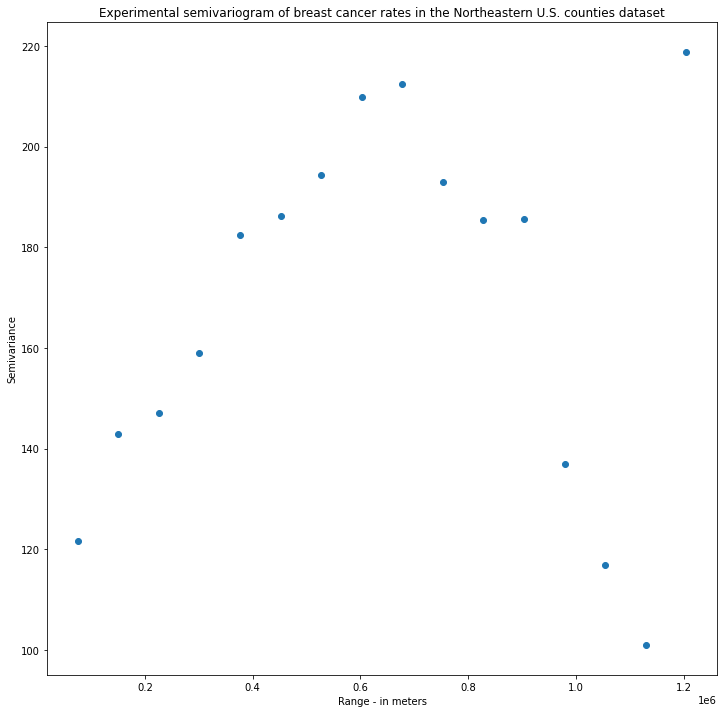

In [17]:
# Experimental semivariogram

search_radius = step_sizes[1]
max_range = maximum_range

exp_semivar = calculate_semivariance(data=areal_centroids, step_size=step_sizes[2], max_range=maximum_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1], 'o')
plt.title('Experimental semivariogram of breast cancer rates in the Northeastern U.S. counties dataset')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

## 4) Calculate experimental semivariogram from point cloud.

You may calculate semivariogram directly, like in the cell above, or from the point cloud. Latter is useful when you perform outliers detection and you remove some of them. Let's check it for our dataset without outliers.

In [18]:
experimental_semivariogram_from_pt_cloud = calc_semivariance_from_pt_cloud(cloud_without_outliers)

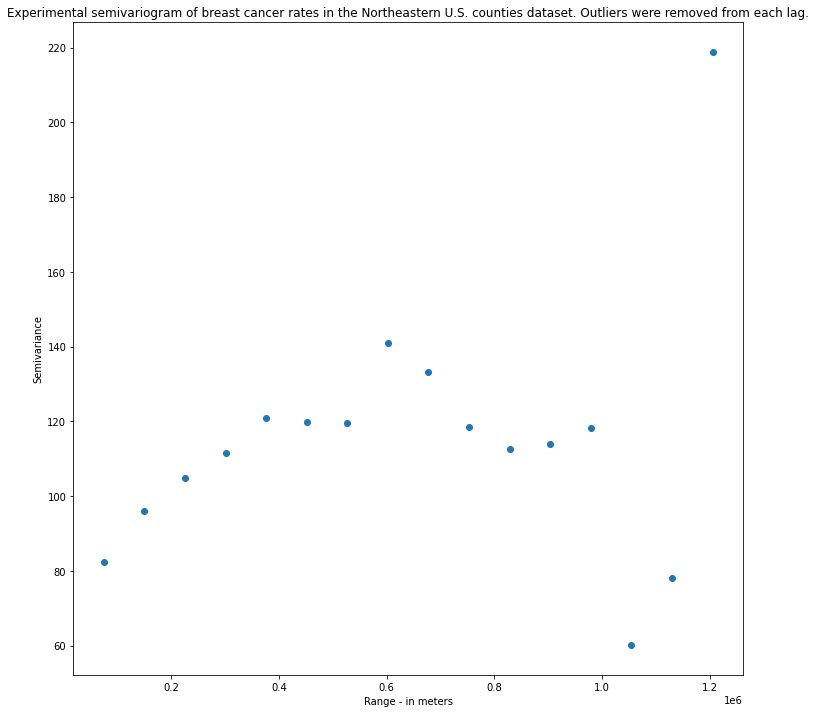

In [19]:
# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(experimental_semivariogram_from_pt_cloud[:, 0], experimental_semivariogram_from_pt_cloud[:, 1], 'o')
plt.title('Experimental semivariogram of breast cancer rates in the Northeastern U.S. counties dataset. Outliers were removed from each lag.')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

As you may noticed, shape of the semivariogram is preserved but values of semivariance are much smaller for the data without outliers.

## 5) What next?

From this point you may look into **Outliers and Their Influence on the Final Model (Intermediate)** notebook where we are exploring the variogram point clouds further.

---